# Data Preprocessing

In [1]:
#!pip install -r requirements.txt


In [2]:

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import collections
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import copy
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [4]:

def tweet_clean(text, combined_pat, negations_dic,neg_pattern):
    clean1 = BeautifulSoup(text, 'lxml')
    clean2 = clean1.get_text()
    clean2.replace("ï¿½", "?")
    clean3 = re.sub(combined_pat, '', clean2)
    #remove upcases
    lower_case = clean3.lower()
    clean4 = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    #remove the non-letters
    clean5 = re.sub("[^a-zA-Z]", " ", clean4)
    tok = WordPunctTokenizer()
    words= [x for x in tok.tokenize(clean5) if len(x)>1]
    #remove the extra spaces
    clean = (" ".join(words)).strip()
    return clean
  
def plot_word_cloud(n, clean_df):
    #create a series with the most used words for positive/negative labels
    #n=1: positive tweets
    #n=0: negative tweets
    sent_tweets = clean_df[clean_df.sentiment == n]
    sent_string = []
    for t in sent_tweets.text:
        sent_string.append(t)
    sent_string = pd.Series(sent_string).str.cat(sep=' ')
    #show the most 100 used words
    wordcloud = WordCloud(width=2000, height=1000,colormap="viridis",max_words=100,background_color='white').generate(sent_string)
    plt.figure(figsize=(16,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return(sent_string)
  
def plot_words(sent_string):
    words = {}
    for word in sent_string.split():
        if word not in words:
            words[word] = 1
        else:
            words[word] += 1
    word_counter = collections.Counter(words)
    common = word_counter.most_common(20)
    data_sent = pd.DataFrame(common, columns = ['Word', 'Count'])
    data_sent.plot.bar(x='Word',y='Count')
    return(words)
    
def accuracy_model(PL, x_train, y_train,x_validation, y_validation): #PL is the pipeline
    t0 = time()
    sentiment_fit = PL.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_validation)
    train_test_time = time() - t0
    model_accuracy = accuracy_score(y_validation, y_pred)
    print ("Accuracy score: "+ str(round(model_accuracy*100,2)))
    print ("Train and test time: "+ str(round(train_test_time,2))+" s")
    print ("--------"*10)
    return model_accuracy, train_test_time
  
def n_feature_tuner(vectorizer, n_features_list, stop_words, ngram_range, classifier, x_train, y_train,x_validation, y_validation):
    L = []
    classcopy=copy.copy(classifier)
    vectcopy=copy.copy(vectorizer)
    print (classcopy)
    print ("\n")
    for n in n_features_list:
        vectcopy.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        PL = Pipeline([('vectorizer', vectcopy),   ('classifier', classcopy)])
        print ("Validation result for "+ str(n)+ " " + " tokens:")
        nfeat_acc,time = accuracy_model(PL, x_train, y_train, x_validation, y_validation)
        L.append((n,nfeat_acc,time))
    return L

def model_tuner(vectorizer, n_features, stop_words, ngram_range, classifier,x_train, y_train):
    vectcopy=copy.copy(vectorizer)
    classcopy=copy.copy(classifier)
    vectcopy.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    PL = Pipeline([('vectorizer', vectcopy),   ('classifier', classcopy)])
    sentiment_fit =PL.fit(x_train, y_train)
    return sentiment_fit
  
def performance_report(model,x,y) :
    y_pred=model.predict(x).astype('int32')
    conf_matrix=pd.DataFrame(np.array(confusion_matrix(y, y_pred, labels=[0,1])), 
    index=['True Negatives', 'True Positives'],columns=['Predicted Negatives','Predicted Positives'])
    accuracy = accuracy_score(y, y_pred)
    target_names=["Negative","Positive"]
    performance_report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
    print("\n")
    print(conf_matrix)
    print("\n")
    print(classification_report(y, y_pred, target_names=target_names))
    return(y_pred,conf_matrix,accuracy,performance_report)
    

The first step is to analyze the structure of our Dataset and the different features.

The training dataset contains :

1 - Sentiment : 0 for negative snetiment, 4 for positive sentiment

2 - The tweet's ID

3 - The date and time of the Tweet

4 - The presence / not presence of query

5 - The nickname of the user who tweeted

6 - The content(text) of the tweet


The dataset contain 1 600 000 samples.
The first 50 % the training dataset are labeled as negative, while the other 50 % as positive.

In [6]:
columns = ['sentiment','id','date','query','user','text']
df = pd.read_csv("/kaggle/input/training1600000processednoemoticoncsv/training.1600000.processed.noemoticon.csv",header=None, names=columns,encoding='cp1252')
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We can clearly notice that only the sentiment label and the text label are only essential. We can get rid of the rest of the features.

Then, to simplify the dataset, we will replace the positive sentiment label 4 by 1.

In [7]:
df.drop(['id','date','query','user'],axis=1,inplace=True)
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## HTML encoding

We notice that some tweets contain few bizzare characters such as "amp" and quot'...

While importing the tweets, html encoding has left these characters that need to be deleted.

We will use the function BeautifulSoup from the library bs4 to clean the data from these encodings.
Beautiful Soup is a library that allows to deal with information on web pages.


In [8]:
#before HTML encoding
print(df.text[145])
print("\n")
#HTML encoding
cleaned = BeautifulSoup(df.text[145], 'lxml')
print (cleaned.get_text())

@twista202 I still haven't read the 9th&amp;10th Princess diaries  Saving Francesca made me cry at the end. Hmm those are easy books.


@twista202 I still haven't read the 9th&10th Princess diaries  Saving Francesca made me cry at the end. Hmm those are easy books.


## Mentions and hashtags

Some tweets contain some mentions of other Twitter users (@user) or some hashtags. We will delete these mention signs and the names of the mentionned users as they have no importance in sentiment analysis using the function re.

However, the hashtaged content could have important information. So, we'll keep it and just get rid of the hashtag symbool '#'.

A RegEx, or Regular Expression, is a sequence of characters that forms a search way. It can be used to check whether a string contains the specified search pattern or not.


In [9]:
#before removing mentions and hashtags
print(df.text[175])

#removing mentions and hashtags
#the '@[A-Za-z0-9]+' is to refer to everything after the @ symbol, which will be deleted.
test=re.sub(r'@[A-Za-z0-9]+','',df.text[175])
test=re.sub(r'#','',test)
print("\n"+test)

@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail

 I'm so sorry you're having to go through this. Again.  therapyfail


## URLs

The URLs in the tweets have no influence on the sentiment analysis process.
We will delete the links using again the library re.

In [10]:
print(df.text[0])
test=re.sub('https?://[A-Za-z0-9./]+','',df.text[0])
print("\n"+test)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


## cp1252 encoding

Some tweets contain the following code sequence cp1252 in the tweets.
It is the cp1252 encoding for the remplacement character �, a symbol inserted to replace a non recognized or inappropriate character.
We will replace it with a '?' characater

In [11]:
print(df.text[226])
test=df.text[226].replace("ï¿½", "?")
print("\n"+test)

Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 

Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers 


## Data Clean

It is about time we bring together the previously introduced data cleaning fucntions and merge them into one.

However, more changes need to be done on the cleaning functions.
We can see that negation words lost their meaning when we remove the special characters inclunding " ' ". 

Example : Can't becomes can t.

So, the word "can" may give positive impression while it should have done the opposite.

Therefore, we should treat the cases with such ambiguities.

Some websites also don't always include a "http" reference at the start of the website adress. Some website adresses published in the tweets go like : "www.google.com". We should also take that into consideration. The used method only detects alphabet, number, period, slash. Some other special characters are not detected like "=", "_", "~", etc.

Besides, a minor detail should be considered regarding the mentions of twitter IDs : Some IDs main contain the character "_".

So, the '@[A-Za-z0-9]+' won't be enough.

We will use the function WordPunctTokenizer from nltk.tokenize associated to the libray Natural Language Toolkit (nltk) built to work with human language. More about the library is detailed in the documentation.

After defining the clean function, we will execute the treatement on the first 100 samples and see the 6 of them in order to not overload the screen.

In [12]:
tok = WordPunctTokenizer()

#combine pattern to the content of the web page and mentions
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
pat3 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2,pat3))
#transform the negation forms
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not",
                }
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [13]:
#the cleaning process for first  100 examples
data_test = df.text[:100]
test_result = []
for t in data_test:
    test_result.append(tweet_clean(t, combined_pat, negations_dic,neg_pattern))

/tmp/ipykernel_34/3459822246.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean1 = BeautifulSoup(text, 'lxml')


#tweets before clean
L=[0,11,20,32,36,49]
for i in L:
    print(df.text[i])
#tweets after clean
print("\n")
for i in L:
    print(test_result[i])

Now, let us apply this data cleaning function to our whole training dataset.
Since the dataset is too large and takes a long processing time, we will make checkpoints for every 50 000 samples.

We will only show the verification on th first 750000 tweets in order to not overload the screen.

Then, we will convert the cleaned data with the corresponding labels into a csv file.

In [14]:
cleaned_tweets = []
for i in range(0, 1600000):
    if ((i+1)%50000 == 0) :
        print ("%d of 1600000 tweets cleaned" % (i+1))
    cleaned_tweets.append( tweet_clean(df['text'][i], combined_pat, negations_dic,neg_pattern))

/tmp/ipykernel_34/3459822246.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean1 = BeautifulSoup(text, 'lxml')


50000 of 1600000 tweets cleaned
100000 of 1600000 tweets cleaned
150000 of 1600000 tweets cleaned
200000 of 1600000 tweets cleaned
250000 of 1600000 tweets cleaned
300000 of 1600000 tweets cleaned
350000 of 1600000 tweets cleaned
400000 of 1600000 tweets cleaned
450000 of 1600000 tweets cleaned
500000 of 1600000 tweets cleaned
550000 of 1600000 tweets cleaned
600000 of 1600000 tweets cleaned
650000 of 1600000 tweets cleaned
700000 of 1600000 tweets cleaned
750000 of 1600000 tweets cleaned
800000 of 1600000 tweets cleaned
850000 of 1600000 tweets cleaned
900000 of 1600000 tweets cleaned
950000 of 1600000 tweets cleaned
1000000 of 1600000 tweets cleaned
1050000 of 1600000 tweets cleaned
1100000 of 1600000 tweets cleaned
1150000 of 1600000 tweets cleaned
1200000 of 1600000 tweets cleaned
1250000 of 1600000 tweets cleaned
1300000 of 1600000 tweets cleaned
1350000 of 1600000 tweets cleaned
1400000 of 1600000 tweets cleaned
1450000 of 1600000 tweets cleaned
1500000 of 1600000 tweets cleaned


In [16]:
clean_data = pd.DataFrame(cleaned_tweets,columns=['text'])
clean_data['sentiment'] = df.sentiment
clean_data.to_csv('/kaggle/working/clean_tweet.csv')
clean_data.head()

,text,sentiment
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


Some tweets are empty after the data perprocessing because they originally contained only URL links or mentions, or they were just empty text from the beginning. 

We will proceed to simply delete these instances as we have no intrest in keeping empty tweets. They will just slow the learning. 

In [17]:
clean_df = pd.read_csv('/kaggle/working/clean_tweet.csv',index_col=0,  dtype=str)
clean_df["sentiment"]=clean_df["sentiment"].astype('int32')
clean_df.reset_index(drop=True,inplace=True)
clean_df.dropna(inplace=True)

# Data visualisation and data Analysis

To get an overall idea of what data are we treating and what are the most frequent words that will be encoutered, it is best to visualize them in simple method. 

We will start by the positive labels, then the negative ones.

plot_word_cloud creates a series with the most used words for positive/negative labels and shows the most 100 used words

n=1: positive tweets

n=0: negative tweets


plot_words plots the histograms



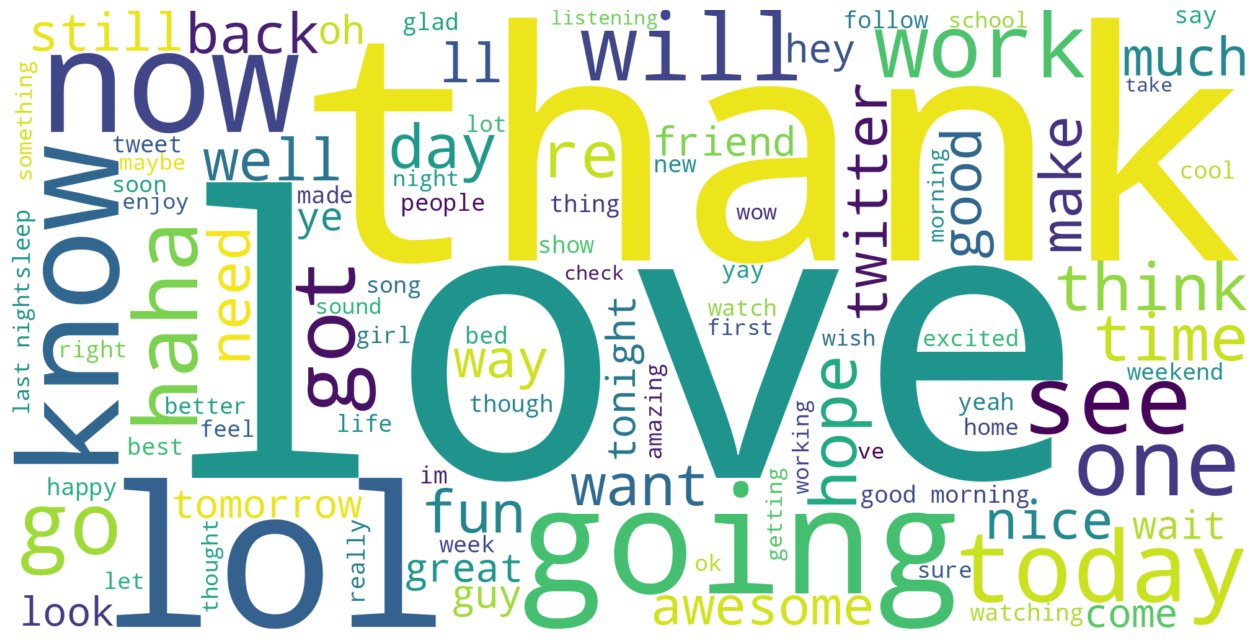

In [18]:
#plot positive-labeled tweets
pos_string=plot_word_cloud(1,clean_df)

This figure shows most of the frequent words for positive tweets. Word cloud may not show the top frequently used words, but it shows some of the words frequetly encountered in the positive reviews.

To make sure we check the most frequently used words, we will place the words in a dictionnary as keys and their frequency as values, and then plot the number of occurences of the top 20 words. 

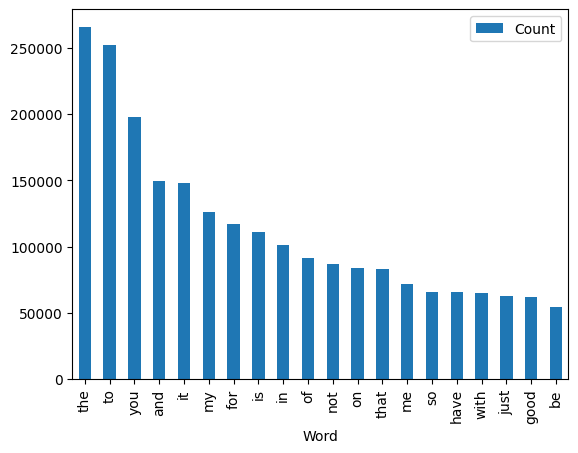

In [19]:
words1=plot_words(pos_string)

We will proceede with the same steps for the negative-labeled tweets.

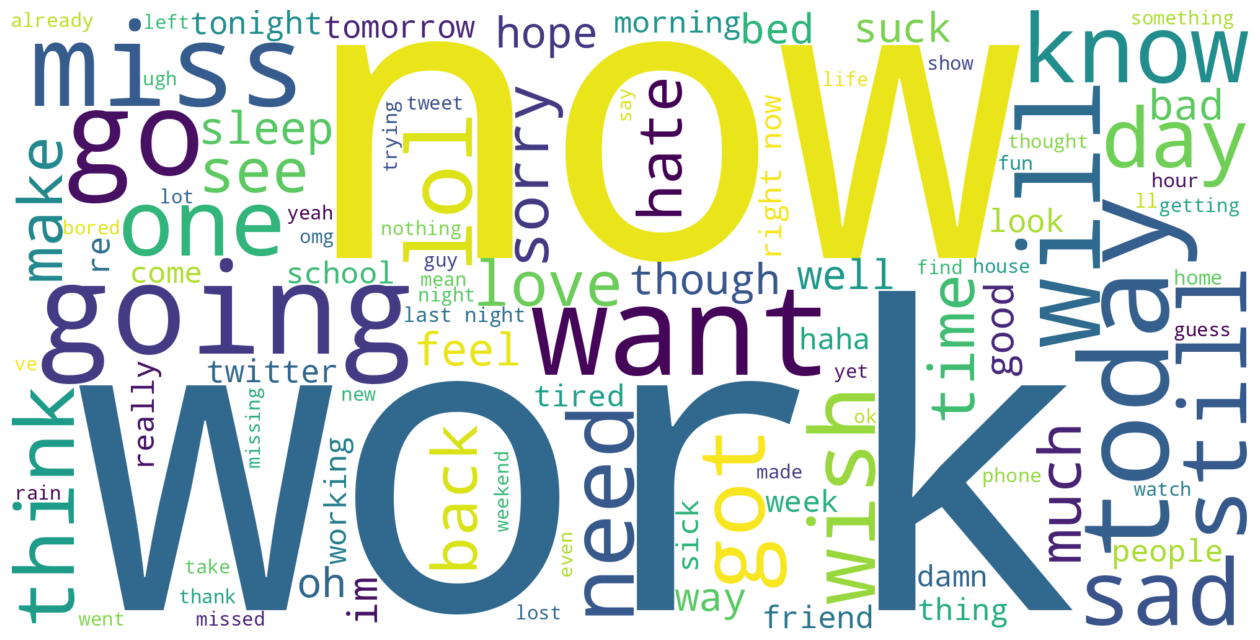

In [20]:
#plot negative-labeled tweets
neg_string=plot_word_cloud(0,clean_df)

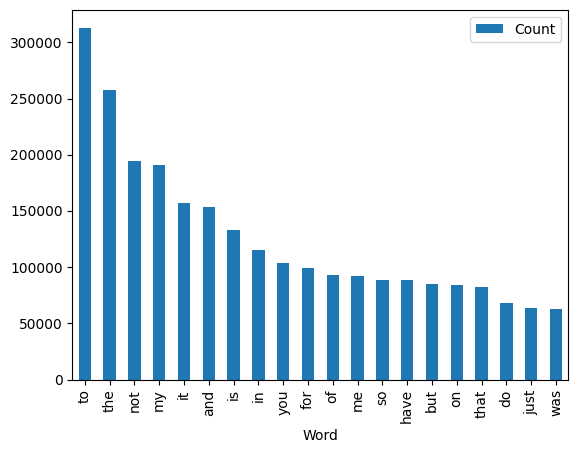

In [21]:
words2=plot_words(neg_string)

It is shown that the most frequent words do not relate to whether the text is classified as positive or negative. They are words used in every speech. They are called stop words.

We will deal with stop words later. As for now, we will treat the data as it is. For analysis purposes, we will calculate the frequencies for each word in all the dataset and store all the results in a .csv file.
Then, we will check the first 10 rows of the dataset(th first 10 most frequent ones).

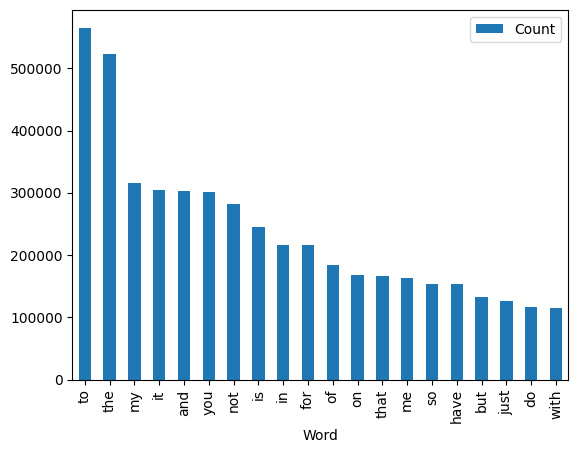

In [22]:
#all_terms(positive and negative tweets)
all_string=pos_string+' '+neg_string
words3=plot_words(all_string)

In [24]:
#all_words total count, count in poitive labels and count in negative labels sorted by total count
words3={k: v for k, v in sorted(words3.items(), key=lambda item: item[1],reverse=True)}
all_words=pd.DataFrame.from_dict(words3, orient='index',columns=['Count'])
all_words=pd.merge(all_words,pd.DataFrame.from_dict(words2, orient='index',columns=['Negative']),how='outer',left_index=True,right_index=True)
all_words=pd.merge(all_words,pd.DataFrame.from_dict(words1, orient='index',columns=['Positive']),how='outer',left_index=True,right_index=True)
all_words.sort_values(by=['Count'],ascending=False,inplace=True)
all_words=(all_words.fillna(0)).astype(int)
all_words.to_csv('/kaggle/working/WordsFreq.csv',encoding='cp1252')
all_words.head(10)

,Count,Negative,Positive
to,565729,313162,252567
the,523834,257836,265998
my,316730,190775,125955
it,305234,157448,147786
and,303600,153958,149642
you,302089,103844,198245
not,281585,194724,86861
is,244623,133432,111191
in,216702,115542,101160
for,216368,98999,117369


It would be intresting to check the overall curve of the most used words for a greater number of words(400).

For that we will plot the first 500 ranks in the x-axis and the frequencies of the corresponding words in the y-axis.

In [ ]:
plt.figure(figsize=(16,8))
ranks=np.arange(400)
plt.bar(ranks, list(all_words["Count"].values)[:400],align='center', alpha=0.5 )

The curve seems alot like a descending exponential function.
In the context of Natural Language Processing, the Sipf's law is a discrete probability distribution that estimates the probability of encountering a word in a given set of words(corpus).

The estimation is given by:
f(r)=A . (1/r^s), where r is the rank(in terms of frequency) of that word in the given corpus. 

A is just a propotional parameter(it should be the first-ranked word's frequency.
s=1 in general or close to 1.

Let us plot the Sipf's law distribution on the same graph with the data distributions.

In [ ]:
plt.figure(figsize=(16,8))
y_zipf= list(all_words["Count"].values)[0]/(np.arange(1,401))
plt.bar(ranks, list(all_words["Count"].values)[:400],align='center', alpha=0.5 )
plt.plot(ranks, y_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('The top 400 tokens')

It is remarquable that most words don't follow the distrubution. The curve is a "near-Zipf" one.

Maybe the cause is the nature of thedataset(tweets) or maybe because of the stop words being used very often.

But, what if the stop words are removed from the data?
Will it give more significant and clearer results?

For the following part, we will use CountVectorizer. Its CounVectoriezr's documentation is found in this reference.

It will help us to consider the whether to count stop words or not.

In [ ]:
countvectorizer = CountVectorizer(stop_words='english',max_features=10000)
countvectorizer.fit(clean_df.text)
countvectorizer

The set of words in the text(tweets) is noted V, and the number of types is the word token vocabulary size |V|, refering to the number of unique words. Tokens are the total number N of all the running words including repetitons.

countvectorizer.fit(clean_df.text) takes all the words in all the sentences and builds a list containing all the words, with respect to the countvectorizer parameters.

Since max_features=10000 and stop_words='english', it will build a list of the m=10000 most frequent words, excluding the stop words. Then, with countvectorizer.transform(clean_df.text) we will get a matrix (nxm), where n=1596041 is the number of tweets.

Each line represents a tweet and each column contains the occurences of those words(types) in the sentences.

So, the value obtained in the i-th line and j-th column, is the occurence of the j-th word (rank j in the previous list) in the i-th tweet.

We can verify the dimension of the list and the obtained matrix.

In [ ]:
#verify the number of tekens and number of tweets 
twwets_tokened = countvectorizer.transform(clean_df.text)
print("Size of the unique words list :" + str(len(countvectorizer.get_feature_names())))
print(twwets_tokened.shape)

We will now check the frequencies of the words in each set of examples (seperated into a negative-labeled set and positive-labeled one) after removing the stop words.

In [ ]:
#n_neg and n_pos are respectively the number of negative-labeled and positive-labeled features 
n_neg=len(clean_df[clean_df["sentiment"]==0])
n_pos=len(clean_df[clean_df["sentiment"]==1])
neg_batches = np.linspace(0,n_neg,10).astype(int)
i=0
#neg_tf is the frequecy of each word in the negative labels
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(twwets_tokened[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [ ]:
pos_batches = np.linspace(798197,1596041,10).astype(int)
i=0
#pos_tf is the frequecy of each word in the positive labels
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(twwets_tokened[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

In [ ]:
#creation of a dataset with all the words(except stop words) sorted by their total frequencies(descending)
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
tokened_freq = pd.DataFrame([neg,pos],columns=countvectorizer.get_feature_names()).transpose()
tokened_freq.columns = ['negative', 'positive']
tokened_freq['total'] = tokened_freq['negative'] + tokened_freq['positive']
tokened_freq.sort_values(by='total', ascending=False,inplace=True)
tokened_freq.head()

Let's now plot the first 50 nagative-labeled words then the 50 first positive-labeled words.

In [ ]:
plt.figure(figsize=(16,8))
ranks=np.arange(50)
tokened_freqneg=tokened_freq.sort_values(by=['negative'],ascending=False)
plt.bar(ranks, list(tokened_freqneg["negative"].values)[:50],align='center', alpha=0.5 )
plt.xticks(ranks, tokened_freqneg['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title("Negative words")

In [ ]:
plt.figure(figsize=(16,8))
ranks=np.arange(50)
tokened_freqpos=tokened_freq.sort_values(by=['positive'],ascending=False)
plt.bar(ranks, list(tokened_freqpos["positive"].values)[:50],align='center', alpha=0.5 )
plt.xticks(ranks, tokened_freqpos['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title("Positive words")

It's true that we got rif of alot the stop words, but there are still "neutral" words such as day or did that don't really refer to a positive or negative snetiment.

In fact, these words appear in both classes with nearly equal frequencies.

So, how ca wen consider that word gives a meaning to the sentiment classification.

We can filter our words (the 10 000 tokens) and get only those whose max(positive_frequency,negatice_frequency)/total_frequency is superior to a certain threshhold (certainly >0.5), but then wel will lose alot of tekns and it will mess the training.

We will keep all the 10 000 tokens for the moment.

# Train/Test process

First, the dataset must be divided into train and test. However, training on the whole dataset and then feeding the model to the test may not be very effective.

However, comparing models performance may be a complicated task.

Given a dataset, there is an approach called k-Cross validation. As we take our training dataset and we randomly divide it into k folds(groups). For each iteration, we take one of the folds and use it as test, while the rest of the data is used to train the model and fit the parameters to it. The process is iterated while changing the test fold each time.

Then, the average performance for each model obtained is refered as the criteria to select the most performant model.

The different models can be the same from a general point of view ,but their hyperparameters differ. So, they are technically not the same and behave differently.

In fact, a hyperparameter is different from a parameter (model parameter).
The model parameters are interior to the model and are estimated from the data. therefore they are saved as a part of the learned model. We often obtain the values of the parameters by optimization and minimization problems.

However, hyperparameters are a configuration that is external to the data and do not result from data estimation.

Being manually specified by the practiotioner, they are tuned for a given predictive modeling problem. We are nt capable to know their best value, but it is about tuning the hyperparameters of the model to discover the optimal parameters of the model resulting in the best performance.

The other approach of validation is Train-Validation-Test Split. The whole dataset is split into 3 parts. The first (the largest one) is used for training. The validation set is used for model selection. The last set is used to test the performance of the slected model.

We will use this approach in our problem. Since our data contains more than 1 500 000 samples, a 1% of the data for validation and another 1% for test would be more than enough.

After splitting our data, we will create a csv data file for each split part.

In [25]:
#train_test_split is used to split the data as described above

x = clean_df.text
y = clean_df.sentiment
SEED = 2500
#first, data is split into train/(validation+test) sets
x_train, x_validation_test, y_train, y_validation_test = train_test_split(x, y, test_size=.02, random_state=SEED)
#then, validation set is split into dev and test sets
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=.5, 
                                                              random_state=SEED)

In [27]:
#creating a dataset for each set and checking the frequency of positive twwets for each one 
df_train=x_train.to_frame(name="text")
df_train["sentiment"]=y_train
df_validation=x_validation.to_frame(name="text")
df_validation["sentiment"]=y_validation
df_test=x_test.to_frame(name="text")
df_test["sentiment"]=y_test

print("Percentage pf positive tweets in the training set : " + 
      str (round(100*(df_train[df_train["sentiment"]==1].shape[0])/df_train.shape[0],2)))
print("Percentage pf positive tweets in the validation set : " + 
      str (round(100*(df_validation[df_validation["sentiment"]==1].shape[0])/df_validation.shape[0],2)))
print("Percentage pf positive tweets in the test set : " + 
      str (round(100*(df_test[df_test["sentiment"]==1].shape[0])/df_test.shape[0],2)))

df_train.to_csv('/kaggle/working/train_tweet.csv',encoding='cp1252')
df_validation.to_csv('/kaggle/working/validation_tweet.csv',encoding='cp1252')
df_test.to_csv('/kaggle/working/test_tweet.csv',encoding='cp1252')

Percentage pf positive tweets in the training set : 49.99
Percentage pf positive tweets in the validation set : 49.74
Percentage pf positive tweets in the test set : 49.88


The frequency for each set are close to 0.5. So, the split is fair  enough to keep.

As we have explained before, text processing requires a numerical representation of the data to feed to the models, because ML algorithms dannot work with raw text data. This process is called feature extraction. We will use the Bag-of-Words(BoW) model for this process. 

We will first define 2 functions that will train different models and calculate their accuracy to compare them. It would be possible using Pipelines.

A pipeline is to sequentially apply a list of transforms and a final estimator by merging them into one and hence, automate the machine learning process. It is extremely useful by grouping sequence of steps in processing the data.

Pipelining is applied transforming features by normalzing them, converting text into vectors, filling up missing data...

However, it is also meant to predict variables by fitting algorithms (estimators) .

So, in a pipeline, the list of transformers is first sequentially applied, then comes the processing of the final estimator.

## Count Vectorizer

### Unigram

We will compare the performances of logistic regression when we apply a Count Vectorizer while removing the stop words from the tokens, while we remove a number of most frequent words and when we keep all the tokens; each with a number of maximum tokens from 1000 to 10000.

In [28]:
n_features_list=np.arange(1,11)*10000
CV=CountVectorizer()
LR=LogisticRegression(solver='liblinear')
print("Logistic Regression using unigrams and removing stop words")
feature_result1 = n_feature_tuner(CV,n_features_list,'english',(1,1),LR, x_train, y_train,x_validation, y_validation)

Logistic Regression using unigrams and removing stop words
LogisticRegression(solver='liblinear')


Validation result for 10000  tokens:


KeyboardInterrupt: 

In [ ]:
print("Logistic Regression using unigrams and keeping all the words")
feature_result2 = n_feature_tuner(CV,n_features_list,None,(1,1),LR, x_train, y_train,x_validation, y_validation)

Let's try to remove the top most frequent 10 words, then the most frequent 50 words an finally 100 words.
We will then have 3 customized stopwords list.

In [ ]:
top_10=frozenset(list(all_words.iloc[:10].index))
top_50=frozenset(list(all_words.iloc[:50].index))
top_100=frozenset(list(all_words.iloc[:100].index))
print("Logistic Regression using unigrams with a customized 10-token stop words list")
feature_result3 = n_feature_tuner(CV,n_features_list,top_10,(1,1),LR, x_train, y_train,x_validation, y_validation)

In [ ]:
print("Logistic Regression using unigrams with a customized 50-token stop words list")
feature_result4 = n_feature_tuner(CV,n_features_list,top_50,(1,1),LR, x_train, y_train,x_validation, y_validation)

In [ ]:
print("Logistic Regression using unigrams with a customized 100-token stop words list")
feature_result5 = n_feature_tuner(CV,n_features_list,top_100,(1,1),LR, x_train, y_train,x_validation, y_validation)

We have tried different versions of logistic regression applied on unigram tokens. The difference consisted in the tokenizer parameters(number of tokens and the stop words used).

Let us plot the different accuracy curves and try to compare them.

In [ ]:
feature_result1DF = pd.DataFrame(feature_result1,columns=['Num_features','validation_accuracy','time'])
feature_result2DF = pd.DataFrame(feature_result2,columns=['Num_features','validation_accuracy','time'])
feature_result3DF = pd.DataFrame(feature_result3,columns=['Num_features','validation_accuracy','time'])
feature_result4DF = pd.DataFrame(feature_result4,columns=['Num_features','validation_accuracy','time'])
feature_result5DF = pd.DataFrame(feature_result5,columns=['Num_features','validation_accuracy','time'])

%matplotlib inline
plt.figure(figsize=(12,9))
plt.plot(feature_result1DF.Num_features, feature_result1DF.validation_accuracy, label='Stop words= English',linewidth=3)

plt.plot(feature_result2DF.Num_features, feature_result2DF.validation_accuracy, label='Stop words= None',linewidth=3)
plt.plot(feature_result3DF.Num_features, feature_result3DF.validation_accuracy, label='Stop words= Top 10 Frequent',linewidth=3)
plt.plot(feature_result4DF.Num_features, feature_result4DF.validation_accuracy, label='Stop words= Top 50 Frequent',linewidth=3)
plt.plot(feature_result5DF.Num_features, feature_result5DF.validation_accuracy, label='Stop words= Top 100 Frequent',linewidth=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison of the different Logistic Regression models using Unigrams")
plt.xlabel("Number of Tokens")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

It may not seem to make alot of sense, but using stop words and increasing their number in the word vectorizer has only lowered the accuracy of the model. Surprisingly, the best performance was obtained by dropping none of the words and keeping the standard word tokenizer.

Now, we will consider training the data with a different algorithm: Support vector machines. However, we will not consider stop_words for tokenizing since it has not proven its efficiency in training.

We will try to tune the hyperparameters C which is the regularization parameter (the less the value C is, the wider the margin is) and the penalty 'l1' or 'l2' which is a parameter to control linear sum of slack variables in the optimization objective function or a square sum of slack variables.

Then, we will compare the performances in term of accuracy by plotting the obtained accuracy scores for the different classifiers.

In [ ]:
SV1=LinearSVC(penalty="l1", dual=False,C=1)
SV2=LinearSVC(penalty="l1", dual=False,C=5)
SV3=LinearSVC(penalty="l1", dual=False,C=10)
SV4=LinearSVC(penalty="l1", dual=False,C=100)
#SV5=LinearSVC(penalty="l2", dual=False,C=1)
#SV6=LinearSVC(penalty="l2", dual=False,C=5)
#SV7=LinearSVC(penalty="l2", dual=False,C=10)
#SV8=LinearSVC(penalty="l2", dual=False,C=100)

print("Logistic Regression using different SVM classifiers \n")
feature_result6 = n_feature_tuner(CV,n_features_list,None,(1,1),SV1, x_train, y_train,x_validation, y_validation)

In [ ]:
feature_result7 = n_feature_tuner(CV,n_features_list,None,(1,1),SV2, x_train, y_train,x_validation, y_validation)

In [ ]:
feature_result8 = n_feature_tuner(CV,n_features_list,None,(1,1),SV3, x_train, y_train,x_validation, y_validation)

In [ ]:
feature_result9 = n_feature_tuner(CV,n_features_list,None,(1,1),SV4, x_train, y_train,x_validation, y_validation)

In [ ]:
#SVM with l2 penalty
#feature_result10 = n_feature_tuner(CV,n_features_list,None,(1,1),SV5)
#feature_result11 = n_feature_tuner(CV,n_features_list,None,(1,1),SV6)
#feature_result12 = n_feature_tuner(CV,n_features_list,None,(1,1),SV7)
#feature_result13 = n_feature_tuner(CV,n_features_list,None,(1,1),SV8)


SVM models with "l2" penalty take much higher time in computation. So we will consider only those with "l1".

In [ ]:
feature_result6DF = pd.DataFrame(feature_result6,columns=['Num_features','validation_accuracy','time'])
feature_result7DF = pd.DataFrame(feature_result7,columns=['Num_features','validation_accuracy','time'])
feature_result8DF = pd.DataFrame(feature_result8,columns=['Num_features','validation_accuracy','time'])
feature_result9DF = pd.DataFrame(feature_result9,columns=['Num_features','validation_accuracy','time'])
#feature_result10DF = pd.DataFrame(feature_result10,columns=['Num_features','validation_accuracy','time'])
#feature_result11DF = pd.DataFrame(feature_result11,columns=['Num_features','validation_accuracy','time'])
#feature_result12DF = pd.DataFrame(feature_result12,columns=['Num_features','validation_accuracy','time'])
#feature_result13DF = pd.DataFrame(feature_result13,columns=['Num_features','validation_accuracy','time'])

%matplotlib inline
plt.figure(figsize=(12,9))
plt.plot(feature_result6DF.Num_features, feature_result6DF.validation_accuracy, label='penalty=l1, C=1',linewidth=3)
plt.plot(feature_result7DF.Num_features, feature_result7DF.validation_accuracy, label='penalty=l1, C=5',linewidth=3)
plt.plot(feature_result8DF.Num_features, feature_result8DF.validation_accuracy, label='penalty=l1, C=10',linewidth=3)
plt.plot(feature_result9DF.Num_features, feature_result9DF.validation_accuracy, label='penalty=l1, C=100',linewidth=3)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison of the different SVM models using Unigrams")
plt.xlabel("Number of Tokens")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

we can say that the Support Vector Machine classifier with C=5 has the best performance
But unlike logistic regression, the performance seems to decrease as we constantly reduce the maximum number of features.
The optimal performance is obtained for about 2000-3000 tokens, which is probably too low consodering there will be much more words in new samples that have no been vectorized.

Below is a comparaison between the selected SVM and the selected logistic regression model.
As predcited, logistic regression performance is higher.

In [ ]:
feature_result7DF

In [ ]:
plt.figure(figsize=(12,9))

plt.plot(feature_result7DF.Num_features, feature_result7DF.validation_accuracy, label='Support Vector Machines',linewidth=3)
plt.plot(feature_result2DF.Num_features, feature_result2DF.validation_accuracy, label='Logistic Regression',linewidth=3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison between SVMs and Logistic regression")
plt.xlabel("Number of Tokens")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

### Bigrams and Trigrams

Now, we will try Logistic regression on text preprocessed to bigrams, as previously by Count Vectorizer. The classifier used is Logistic regression(the one which gave us the best performance for unigrams).

In [ ]:
print("Logistic Regression using unigrams and keeping all the words")
bigram_feature_result1 = n_feature_tuner(CV,n_features_list,None,(1,2),LR, x_train, y_train,x_validation, y_validation)

Let us plot the accuracy curves for Logistic Regression in both cases: Unigrams and Bigrams.

In [ ]:
bigram_feature_result1DF = pd.DataFrame(bigram_feature_result1,columns=['Num_features','validation_accuracy','time'])

plt.figure(figsize=(12,9))

plt.plot(feature_result2DF.Num_features, feature_result2DF.validation_accuracy       , label='Unirams',linewidth=3)
plt.plot(bigram_feature_result1DF.Num_features,bigram_feature_result1DF.validation_accuracy, label='Bigrams',linewidth=3)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison between Unigrams and Bigrams for Logistic Regression")
plt.xlabel("Number of Tokens")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

In [ ]:
print("Logistic Regression using trigrams and keeping all the words")
trigram_feature_result1 = n_feature_tuner(CV,n_features_list,None,(1,3),LR, x_train, y_train,x_validation, y_validation)

Now, the same process is repeated with trigrams. A final comparaison is illustrated for the 3 n-gram cases.

In [ ]:
trigram_feature_result1DF = pd.DataFrame(trigram_feature_result1,columns=['Num_features','validation_accuracy','time'])

plt.figure(figsize=(12,9))

plt.plot(feature_result2DF.Num_features, feature_result2DF.validation_accuracy       , label='Unirams',linewidth=3)
plt.plot(bigram_feature_result1DF.Num_features,bigram_feature_result1DF.validation_accuracy, label='Bigrams',linewidth=3)
plt.plot(trigram_feature_result1DF.Num_features,trigram_feature_result1DF.validation_accuracy, label='Trigrams',linewidth=3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison between Unigrams, Bigrams and Trigrams for Logistic Regression")
plt.xlabel("Number of Tokens")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

It is clear that Trigram bag of words has given the best performance in terms of accuracy.

We can check in the dataframes of the accuracy scores that the best scores are obtained for:

70000 tokens for unigrams : 79.52 %

60000 or 90000 tokens for bigrams : 81.43 %

70000 tokens for trigrams : 81.84 %

To avoid recalculations, we will define a function that takes as parameters the vectorizer along with iys parameters, the classifier and the training set. Then, it will return the model with the tuned parameters to be applied to the validation or test set. 

In [ ]:
#Here are the chosen models for count vectorizer
CV=CountVectorizer()
LR_Unigrams=model_tuner(CV, 70000, None, (1,1), LR ,x_train, y_train) #chosen model for count vectorizer/uni-grams
LR_Bigrams=model_tuner(CV, 90000, None, (1,2), LR ,x_train, y_train)  #chosen model for count vectorizer/bi-grams
LR_Trigrams=model_tuner(CV, 70000, None, (1,3), LR ,x_train, y_train) #chosen model for count vectorizer/tri-grams

## TFIDF Vectorizer

Count vectorizer may not always be the best method to vectorize our dataset. Another way to do so is the TF-IDF vectorizer.

As CountVectorizer, there is module TfidfVectorizer with a similar syntax.

We will proceed with a similar work to the word vectorizer, using Logistic regression. We will start by Unigrams then proceed to bigrams and trigrams for different number of features.

In [ ]:
LR=LogisticRegression(solver='liblinear')
trainnn = pd.read_csv("Data/train_tweet.csv",encoding='cp1252',index_col=0, dtype=str)
x_train=trainnn["text"]
y_train=trainnn["sentiment"].astype('int32')

validationnn = pd.read_csv("Data/validation_tweet.csv",encoding='cp1252',index_col=0, dtype=str )
x_validation=validationnn["text"]
y_validation=validationnn["sentiment"].astype('int32')

testtt = pd.read_csv("Data/test_tweet.csv",encoding='cp1252',index_col=0, dtype=str)
x_test=testtt["text"]
y_test=testtt["sentiment"].astype('int32')

In [ ]:
n_features_list=np.arange(1,11)*10000

In [ ]:
#training Logistic Regression for unigrams, bigrams and trigrams on the different number of tokens
TFIDFVEC = TfidfVectorizer()

In [ ]:
TFIDF_feature_result1=n_feature_tuner(TFIDFVEC,n_features_list,None,(1,1),LR,x_train, y_train,x_validation, y_validation)

In [ ]:
TFIDF_bigram_feature_result1=n_feature_tuner(TFIDFVEC,n_features_list,None,(1,2),LR,x_train, y_train,x_validation, y_validation)

In [ ]:
TFIDF_trigram_feature_result1=n_feature_tuner(TFIDFVEC,n_features_list,None,(1,3),LR,x_train, y_train,x_validation, y_validation)

We will then plot the curve of the evolution of the 3 models accuracy scores. 

In [ ]:
TFIDF_feature_result1DF = pd.DataFrame(TFIDF_feature_result1,columns=['Num_features','validation_accuracy','time'])
TFIDF_bigram_feature_result1DF = pd.DataFrame(TFIDF_bigram_feature_result1,
                                              columns=['Num_features','validation_accuracy','time'])
TFIDF_trigram_feature_result1DF = pd.DataFrame(TFIDF_trigram_feature_result1,
                                               columns=['Num_features','validation_accuracy','time'])


plt.figure(figsize=(12,9))
plt.plot(TFIDF_bigram_feature_result1DF.Num_features, TFIDF_feature_result1DF.validation_accuracy, 
                                                   label='Uni-grams',linewidth=3)
plt.plot(TFIDF_bigram_feature_result1DF.Num_features, TFIDF_bigram_feature_result1DF.validation_accuracy, 
                                                   label='Bi-grams',linewidth=3)
plt.plot(TFIDF_trigram_feature_result1DF.Num_features, TFIDF_trigram_feature_result1DF.validation_accuracy, 
                                                   label='Tri-grams',linewidth=3)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Accuracy comparaison between N-grams for Logistic Regression")
plt.xlabel("Number of Terms")
plt.ylabel("Accuracy of the model on the validation set")
plt.show()

Similarly to the Count vectorizer case, we can see that bi-grams and tri-grams have relatively much higher accuracy scores.

Tri-grams have a better score than bi-grams when the number of terms surpasses 4000.

The best accuracy scores are each case are obtained with a certain number of terms:

100000 tokens for unigrams : 79.77 %

100000 tokens for bigrams : 82.07 %

80000 terms for trigrams : 82.28 %

In [ ]:
#Here are the chosen models for TFIDF vectorizer
TFIDFVEC = TfidfVectorizer()
LR_Unigrams_TFIDF=model_tuner(TFIDFVEC, 100000, None, (1,1), LR ,x_train, y_train) #chosen model for TFIDF vectorizer/uni-grams
TFIDFVEC = TfidfVectorizer()
LR_Bigrams_TFIDF=model_tuner(TFIDFVEC, 100000, None, (1,2), LR ,x_train, y_train)  #chosen model for TFIDF vectorizer/bi-grams
TFIDFVEC = TfidfVectorizer()
LR_Trigrams_TFIDF=model_tuner(TFIDFVEC, 80000, None, (1,3), LR ,x_train, y_train) #chosen model for TFIDF vectorizer/tri-grams

It would be intresting to compare the executed models with the same ones but excluding the stop words from the vectorizer. The executed models without the stop words will give lower accuracy results: they didn't enhance the model. It is kind of explainable as the TFIDF vectorizer gives lower score to the stop words because they are used in many more sentences, so their IDF would probably be very low. Thus, probably a portion of them may not even be a part of the terms list. 


It is clear that TFIDF vectorizers have better perfermance than count vectorizer in term of accuracy for logistic regression.

Here are the detailed classification reports

In [ ]:
print("Logistic Regression - Unigrams")
PR1=performance_report(LR_Unigrams_TFIDF,x_test,y_test)
print("----------------------------------------------------------")
print("Logistic Regression - Bigrams")
PR2=performance_report(LR_Bigrams_TFIDF,x_test,y_test)
print("----------------------------------------------------------")
print("Logistic Regression - Trigrams")
PR3=performance_report(LR_Trigrams_TFIDF,x_test,y_test)

In [ ]:
print("Logistic Regression - Unigrams")
PR1=performance_report(LR_Unigrams,x_test,y_test)
print("----------------------------------------------------------")
print("Logistic Regression - Bigrams")
PR2=performance_report(LR_Bigrams,x_test,y_test)
print("----------------------------------------------------------")
print("Logistic Regression - Trigrams")
PR3=performance_report(LR_Trigrams,x_test,y_test)

In [30]:
TFIDFVEC = TfidfVectorizer()
LR_Trigrams_TFIDF=model_tuner(TFIDFVEC, 80000, None, (1,3), LR ,x_train, y_train) #chosen model for TFIDF vectorizer/tri-grams

In [31]:
print(LR_Trigrams_TFIDF)
print("----------------------------------------------------------")
print("Logistic Regression - Trigrams")
PR3=performance_report(LR_Trigrams_TFIDF,x_test,y_test)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=80000, ngram_range=(1, 3))),
                ('classifier', LogisticRegression(solver='liblinear'))])
----------------------------------------------------------
Logistic Regression - Trigrams


                Predicted Negatives  Predicted Positives
True Negatives                 6515                 1484
True Positives                 1313                 6649


              precision    recall  f1-score   support

    Negative       0.83      0.81      0.82      7999
    Positive       0.82      0.84      0.83      7962

    accuracy                           0.82     15961
   macro avg       0.82      0.82      0.82     15961
weighted avg       0.82      0.82      0.82     15961



In [32]:
y_test_predcted  = LR_Trigrams_TFIDF.predict(x_test)

In [35]:
y_test_predcted.shape

(15961,)

In [36]:
x_test

1034938    welcome here some great twitter tips happy twe...
160949     its from all that anal sex forgot the lube dam...
1421897    crime shows are good friend when no decent tv ...
304118                                             im hurtin
614938     sad that publisher clearinghouse has not stopp...
                                 ...                        
909173     going to see star trek with my babe im actuall...
640729                                            cant sleep
1100661     that girl on bgt was right fake greg was awesome
94202      please give me tix to the harlem globetrotters...
1189477                                 not worried bit nuts
Name: text, Length: 15961, dtype: object

In [47]:
text = "good good"
y_test_predcted_ex  = LR_Trigrams_TFIDF.predict([text])

In [42]:
import pickle
filename = "/kaggle/working/lr_model.sav"
pickle.dump(LR_Trigrams_TFIDF, open(filename, 'wb'))

In [43]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [49]:
loaded_model = pickle.load(open(filename, 'rb'))
text = "good good"
if loaded_model.predict([text])[0] == 1:
    print("Positif")
else :
    print("Negative")

Positif


In [50]:
loaded_model = pickle.load(open(filename, 'rb'))
text = "I feel tired"
if loaded_model.predict([text])[0] == 1:
    print("Positif")
else :
    print("Negative")

Negative
